# Bayesian Statistical Inference: V

*N. Pol (2025)*

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.

---

## Contents
* [Gibbs Sampling](#one)
    * [Benefits Of Gibbs Sampling](#onea)
    * [Drawbacks Of Gibbs Sampling](#oneb)
    * [Conjugate Priors (Again)](#onec)
* [Practical Evidence Evaluation & Model Comparison](#two)
    * [Dynesty](#twoa)
    * [UltraNest](#twob)

---

***<font color='red'>Notebook credit will be given in this lecture for successfully producing plots and output from running the code examples.</font>.***

---

***BEFORE YOU START:*** Please pause for a few minutes and install these packages `dynesty`, `UltraNest` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn. *(The second package you'll install below is just cython, which wraps C code in Python structures.)*

In [1]:
!pip install dynesty

In [2]:
!pip install cython

In [3]:
!pip install ultranest

  Using cached ultranest-4.4.0.tar.gz (2.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build ultranest


  error: subprocess-exited-with-error
  
  × Building wheel for ultranest (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [55 lines of output]
      C:\Users\heide\AppData\Local\Temp\pip-build-env-25yhjdd2\overlay\Lib\site-packages\setuptools\_distutils\dist.py:270: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\heide\AppData\Local\Temp\pip-build-env-25yhjdd2\overlay\Lib\site-packages\setuptools\_distutils\dist.py:270: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-311\ultranest
      copying ultranest\calibrator.py -> build\lib.win-amd64-cpython-311\ultranest
      copying ultranest\dychmc.py -> build\lib.win-amd64-cpython-311\ultranest
      copying ultranest\dyhmc.py -> build\lib.win-amd64-cpython-311\ultranest
      copying ultranest\flatnuts.py -> build\lib.win-amd64

## Gibbs Sampling <a class="anchor" id="one"></a>

**Gibbs sampling** is an MCMC method that avoids acceptance-rejection techniques. Instead, one sweeps through each parameter (or block of parameters) to draw from their ***conditional probability distributions***, with all other parameters fixed to their current values. 

After sampling for a sufficiently large number of Gibbs steps, the principles of MCMC guarantee that **this process of sequential conditional probability drawing will converge to the joint posterior distribution of the overall model parameter space**. A standard Gibbs algorithm is shown below.

---
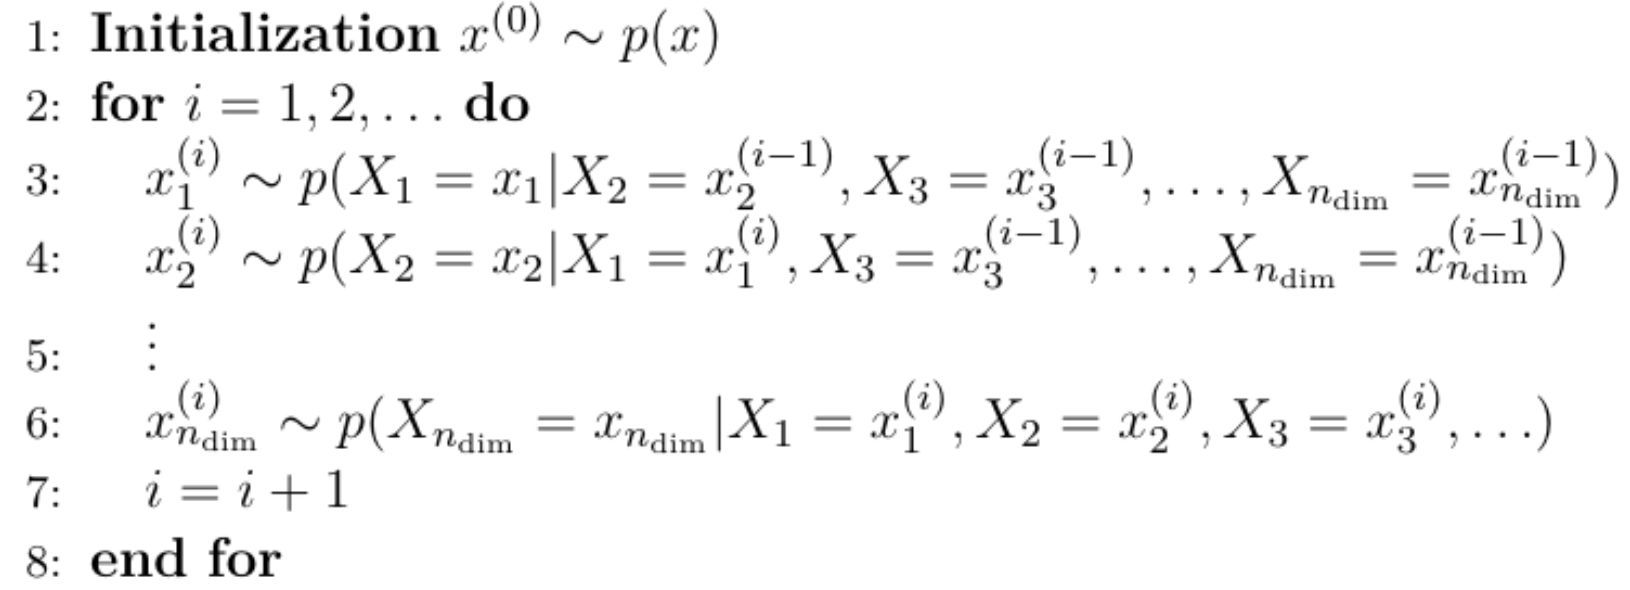

---

To break this algorithm up into words, we

- We initialize the sampler at some random point in parameter space.


- Fix all parameters except the first one. Draw a random value from the conditional posterior probability distribution of this first parameter **given** the fixed values of all other parameters.


- Fix all parameters except the second one. Draw a random value from the conditional posterior probability distribution of this second parameter **given** the fixed values of all other parameters **and the updated value of the first parameter**.


- *et cetera* for all parameters.


- Repeat for many Gibbs steps.



### Benefits of Gibbs Sampling <a class="anchor" id="onea"></a>

- By drawing directly from the posterior conditionals, the **auto-correlation length can be exceptionally small**, with **minimal burn-in**. 
- **It's also fast**; sequential draws directly from the parameter posterior conditionals means that we are not rejecting any points. 

### Drawbacks of Gibbs Sampling <a class="anchor" id="oneb"></a>

- You need to know the form of the conditional probability distributions for each parameter (or parameter blocks), and how to draw samples from it. 
- This can be a non-trivial problem, so typically a lot of effort is placed in manipulating the form of the posterior to find a conditional that is a standard probability distribution. This is where **conjugate priors** become really handy. 

### Conjugate Priors (Again) <a class="anchor" id="onec"></a>

> *These are parameter priors for which the the posterior lies in the same family of distributions as the prior.* 

***EXAMPLE***

- Imagine we have a Gaussian likelihood function with mean $\mu$ and variance $\sigma^2$ parameters. 
- The conjugate prior on $\mu$ when $\sigma^2$ is known (as is assumed in Gibbs when sweeping through each parameter) is a Gaussian distribution.
- Thus the conditional posterior distribution on $\mu$ is simply a Gaussian. 
- Similarly, the conjugate prior on $\sigma^2$ when $\mu$ is an inverse gamma distribution.
- Thus the conditional posterior distribution on $\sigma^2$ is an inverse gamma distribution.


Let's look at the speciifc example we had in `Lecture_11` where we used the `PTMCMCSampler` to generate an MCMC chain of posterior samples of $\mu$ and $\sigma$ for homoescedastic Gaussian data.

#### Metropolis-Hastings Approach

In [5]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
#from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=False)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

In [6]:
# don't worry about any warning messages regarding mpi4py
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

# generating data
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 
data = stats.norm(mu, sigma).rvs(Ndata)

# mcmc functions
#################
def Likelihood(x, data):
    # Gaussian likelihood 
    return np.prod(stats.norm(loc=x[0], scale=x[1]).pdf(data))

def Prior(x):
    # create a uniform prior in mu and sigma
    prior_mu = stats.uniform.pdf(x[0], loc=0.5, scale=1.0)
    prior_sigma = stats.uniform.pdf(x[1], loc=0.1, scale=0.8)
    return  prior_mu * prior_sigma

def logLikelihood(x):
    return np.log(Likelihood(x, data))

def logPrior(x):
    return np.log(Prior(x))
###############


# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logLikelihood, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

Optional mpi4py package is not installed.  MPI support is not available.


In [7]:
# sampler for N steps
N = int(3e4)
x0 = np.array([0.9, 0.3])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent in 0.008047 s Acceptance rate = 0

Finished 33.33 percent in 19.234180 s Acceptance rate = 0.542667Adding DE jump with weight 50
Finished 100.00 percent in 54.966938 s Acceptance rate = 0.608867
Run Complete


Taking every n = 2 samples based on ac length.
Burning first n = 500 samples.


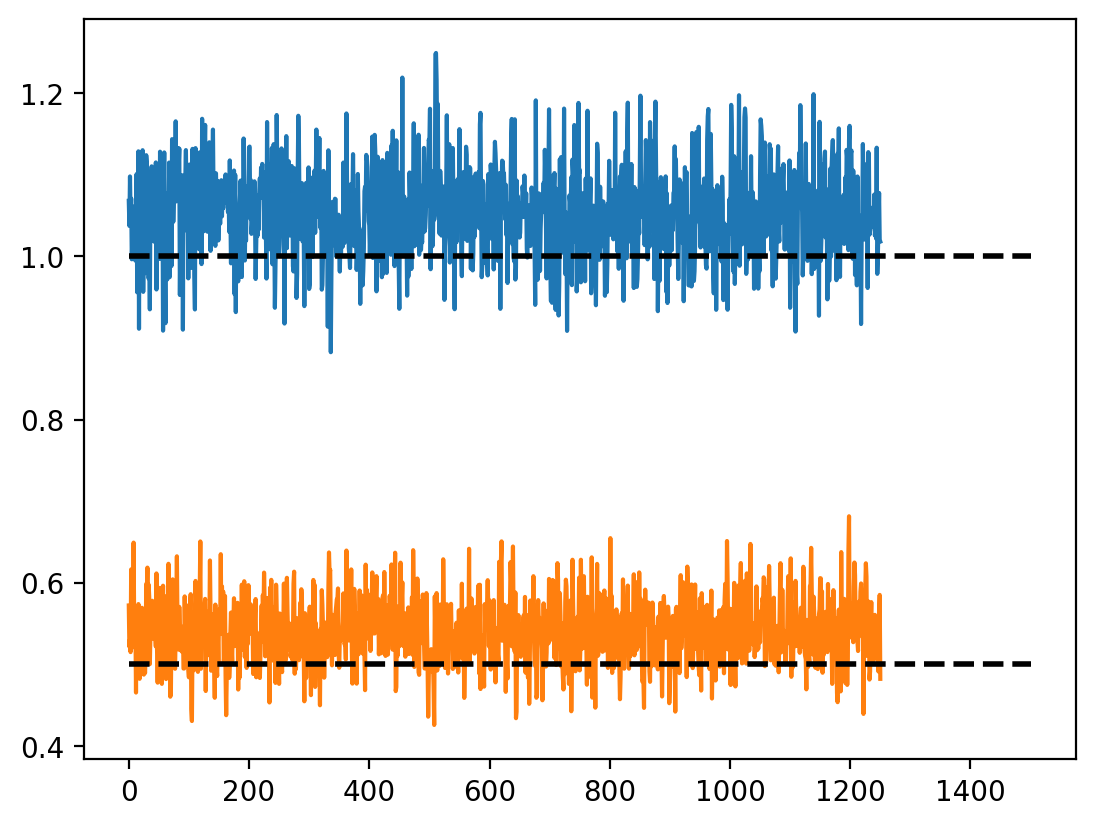

In [17]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

#import acor
#thin = int(acor.acor(chain[:,0])[0])
thin = 2
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(chain[500::thin,0]);
plt.plot(chain[500::thin,1]);

# injected values
plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

**On my machine it took about 30 seconds to get the $3000$ chain samples, of which I burnt the first 500, and took every second sample for autocorrelation thinning. This left me with $1250$ samples generated in 30 seconds with an acceptance rate of $\sim 50\%$.**

#### Gibbs Approach

Code for this example is adapted from https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/, https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html, and https://www.wikiwand.com/en/Conjugate_prior. 

---

To make the Gibbs approach work, we need the conjugate priors for the mean and variance of a Gaussian likelihood. These are a Gaussian for the mean, and an inverse Gamma for the variance. We'll make these broad so that our posterior constraints are data-dominated.

$$ p(\mu) = \mathcal{N}(\mu_0,\sigma_0) = \frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(\frac{-\mu^2}{2\sigma_0^2} \right)$$

where $\mu_0,\sigma_0$ are the location and scale parameters of the Gaussian prior on $\mu$, and 

$$ p(\sigma^2) = \mathrm{IG}(\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} (1/\sigma^2)^{\alpha+1}\exp(-\beta/\sigma^2)$$

where $\alpha,\beta$ are parameters defining the shape of the inverse Gamma prior on $\sigma^2$.

It is algebraically tedious and relatively straightforward to multiply the Gaussian likelihood of the data with each of these priors in turn to work out the posterior conditional distributions on $\mu$ and $\sigma^2$. These turn out to be

$$ p(\mu|\{x_i\}) = \mathcal{N}(\mu_*,\sigma_*)$$

where 

$$\mu_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} \left(\frac{\mu_0}{\sigma_0^2} + \frac{\sum^n_{i=1}x_i}{\sigma^2} \right)$$

$$\sigma^2_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} $$

and 

$$ p(\sigma^2|\{x_i\}) = \mathrm{IG}(\alpha_*,\beta_*)$$

where 

$$ \alpha_* = \alpha + n/2$$

$$ \beta_* = \beta + \frac{\sum^n_{i=1}(x_i-\mu)^2}{2}$$

In [18]:
# conditional of \mu
def p_mu_given_sigma2(sigma2, x, mu0, sigma0):
    sigma_star2 = 1.0 / ( (1.0 / sigma0**2.) + (x.shape[0] / sigma2) )
    mu_star = sigma_star2 * ((mu0/sigma0**2.) + (np.sum(x)/sigma2))
    return np.random.normal(loc=mu_star, scale=np.sqrt(sigma_star2))

# conditional of \sigma^2
def p_sigma2_given_mu(mu, x, alpha, beta):
    alpha_star = alpha + x.shape[0]/2.
    beta_star = beta + np.sum((x-mu)**2.)/2.
    return stats.invgamma.rvs(a=alpha_star, scale=beta_star)


def gibbs_sampling(data, mu_initial, sigma2_initial,
                   mu0, sigma0, alpha, beta, iter=2000):
    samples = np.zeros((iter, 2))
    samples[0,:] = [mu_initial, sigma2_initial]

    for ii in range(1,iter):
        # sequential sampling of posterior conditionals
        ### mu first
        mu_new = p_mu_given_sigma2(samples[ii-1,1], data, mu0, sigma0)
        samples[ii,0] = mu_new
        ### then sigma2
        sigma2_new = p_sigma2_given_mu(samples[ii,0], data, alpha, beta)
        samples[ii,1] = sigma2_new

    return samples

In [19]:
# starting point
mu_initial = 0.2
sigma2_initial = 0.6

# priors
mu0 = 1.0
sigma0 = 0.9
alpha = 1.0
beta = 1.0

## SAMPLE!
def run_gibbs():
    samples = gibbs_sampling(data, mu_initial, sigma2_initial, 
                             mu0, sigma0, alpha, beta)
    return samples

In [20]:
samples = run_gibbs()

Taking every n = 1 samples based on ac length.
Burning first n = 500 samples.


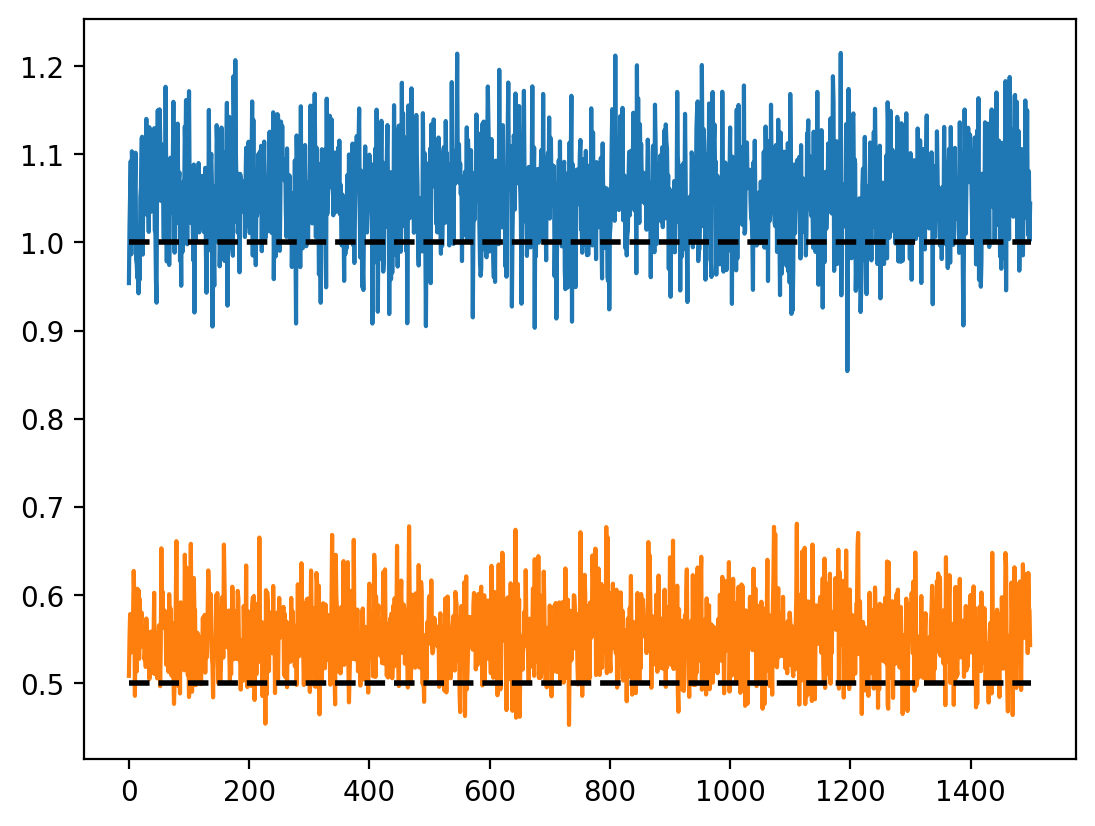

In [24]:
#thin = int(np.round_(acor.acor(samples[:,0])[0]))
thin = 1
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(samples[500::thin,0]); # burned and thinned mean
plt.plot(samples[500::thin,1]**0.5); # burned and thinned sigma

# injected values
plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

Run the following code to time the Gibbs sampling of $2000$ posterior draws. No points are rejected. You'll see that this is about **two orders of magnitude faster than Metropolis-Hastings**, while also giving a greater number of sampled values.

In [25]:
%timeit -n1 run_gibbs()

193 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Gibbs sampling is awesome...provided that you can work out the analytic conditional posteriors as standard distribution forms.** 

But even if you can't, all is not lost. You can get inventive by embedding a short Metropolis-Hastings block within the Gibbs algorithm. For example, if there are parameters for which you can not directly draw from the conditional, then your Gibbs step for that parameter could be a short Metropolis-Hastings MCMC run. 

The goal is to run this sufficiently long enough that you have drawn a single quasi-independent random sample from the parameter posterior conditional distribution, with all other parameters fixed. You can then proceed through the remainder of your Gibbs steps as normal. 

##  Practical Evidence Evaluation & Model Selection <a class="anchor" id="two"></a>

We've discussed Bayesian parameter estimation algorithms in detail. But what about evidence evaluation and model comparison? We already have the AIC and BIC as proxies. Grid-based methods for integrating the likelihood $\times$ prior are far too crude. 

There are some further numerical techniques that we'll briefly discuss, before looking at examples of **Nested Sampling** algorithms to compute the Bayesian evidence. 

### Savage-Dickey Density Ratio

This is great for when we want to compare models that have nested parameters, e.g. (1) a model with just noise, and (2) a model with a signal and noise. We need to be able to identify a parameter in the signal model that acts as an amplitude, $A$, that can effectively switch the signal off when it is zero. 

Thus $p_1(d|n) = p_2(d|A=0,n)$.

With MCMC sampling we can map out the full parameter posterior distribution of model (2). We need to make sure we get good mixing and exploration of the parameter $A$ so that we can reconstruct its posterior density at $A=0$. 

The Bayes factor of Model $2$ (signal and noise) versus Model $1$ (noise alone) can be computed using the **[Savage-Dickey Density Ratio](https://www.jstor.org/stable/2958475?casa_token=Dc8wjaKRj5UAAAAA%3A4IhKgqNXc4jpan6hRxW7tBpXTI4i2236BulPTRxj4FcivD988vqJw-N75Dtw7z4Lh3YtPsDIceS8NDtIXAIRIO1T227h9VYZ2prQpwb46WLBB0GGz8w&seq=1#metadata_info_tab_contents)** approximation,

$$ \mathcal{B} = \frac{\mathcal{Z}_2}{\mathcal{Z}_1} = \frac{p(A=0)}{p(A=0|d,n)}$$

which is the prior density at $A=0$ divided by the conditional posterior density at $A=0$. We can easily compute the latter by making a histogram of posterior samples in $A$ and reading off the normalized pdf at $A=0$.


### Product-space Sampling

Product-space sampling sounds fancy, but is super easy. In this type of model comparison, we never explicitly try to compute the Bayesian evidence. 

- We run a big MCMC chain that includes all parameters of all models, in addition to a model indexing parameter, $n$. 
- We define distinct ranges for this parameter, such that in certain sampling ranges it will trigger one of the model likelihoods to be used, e.g. if $-0.5<n<0.5$ use the likelihood for model $1$. 
- After sampling sufficiently long, the MCMC chain will spend different amounts of time in differnt regions of $n$ in proportion to the Bayesian odds ratio. 
- Hence, the ratio of samples in model sub-ranges of $n$ gives the Bayesian odds ratio. Simple!
- We use this alot in PTA GW searches, see [https://arxiv.org/abs/1801.02617](https://arxiv.org/abs/1801.02617), [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496), and [https://arxiv.org/abs/2006.04810](https://arxiv.org/abs/2006.04810). 
- Refs [here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02042.x) and [here](https://amstat.tandfonline.com/doi/abs/10.1198/10618600152627924?casa_token=Kgpt2ZvdMrcAAAAA%3Al5JB7EitQ7MjPmxBObu2XJXocZCE1tI2-ZAceCwBjJOi2TRajF7SaxFcQjo1Nn5AF9q6vKhkxpBd&#.YEZH4F1KiLo).

### Thermodynamic Integration

This technique is pretty fancy, and is derived from analogies with thermodynamics. It is used for exact calculation of the Bayesian evidence. 

- Many MCMC chains are launched in parallel. However, their likelihoods differ slightly in their "temperature", $T$. We actually use the inverse temperature $\beta=1/T$ when writing the math. The temperature of a chain is used to modify the likelihood as follows, where 

$$ p(d|\theta)_\beta = p(d|\theta)^\beta = p(d|\theta)^{1/T}.$$

- Thus only the $T=0$ chain corresponds to the actual model likelhiood. 
- But the other temperature chains have the effect of taking higher and higher roots of the likelihood, smoothing it out and making it more similar to the original prior. 
- These high temperature chains explore the parameter volume well, communicate back to the $T=0$ chain, and improve MCMC mixing. 
- Crucially, we can also use them in evidence computation:

$$ \ln\mathcal{Z} = \int_0^1 \langle \ln p(d|\theta)\rangle_\beta\, d\beta, $$

where we take the mean log-likelihood of each $\beta$ chain, then sum these over all temperatures to get the log-evidence. Refs [here](https://www.jstor.org/stable/2676756?casa_token=nGU-oa0w6lQAAAAA%3A8UNqj0_rBP7aZ4vocZ_NzbxKhre4WvzhbNOs_TTI_FfexQmppcxQSlxaO5PCHPZNAw9fZUmy4rPeXLe_CVJgAD2AYR6qS8D6xQDicpc1R45ZhjEtOV4&seq=1#metadata_info_tab_contents), and [here](https://link.springer.com/content/pdf/10.1007/BF01406511.pdf).


### Nested Sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. 

- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way. 

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into 

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$

There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product. 

By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


So while this is the big one, there seem to be other more pythonic implementations now on the market. Let's look at those.

---

### Dynesty <a class="anchor" id="twoa"></a>

https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3$D correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [27]:
import dynesty

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Run the sampler. *(You may get some warnings about messages not being able to write out anymore because the buffer was exceeded. Don't worry. Just check the circle in the top right of your notebook to see when it goes from filled to hollow to show that the cell is finished.)*

In [28]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

iter: 4794 | +500 | bound: 8 | nc: 1 | ncall: 24885 | eff(%): 21.710 | loglstar:   -inf < -0.298 <    inf | logz: -9.110 +/-  0.129 | dlogz:  0.001 >  0.509                                          

In [29]:
## "Dynamic" nested sampling.
# COME BACK and RUN THIS IF YOU HAVE TIME AT THE END. 

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs.

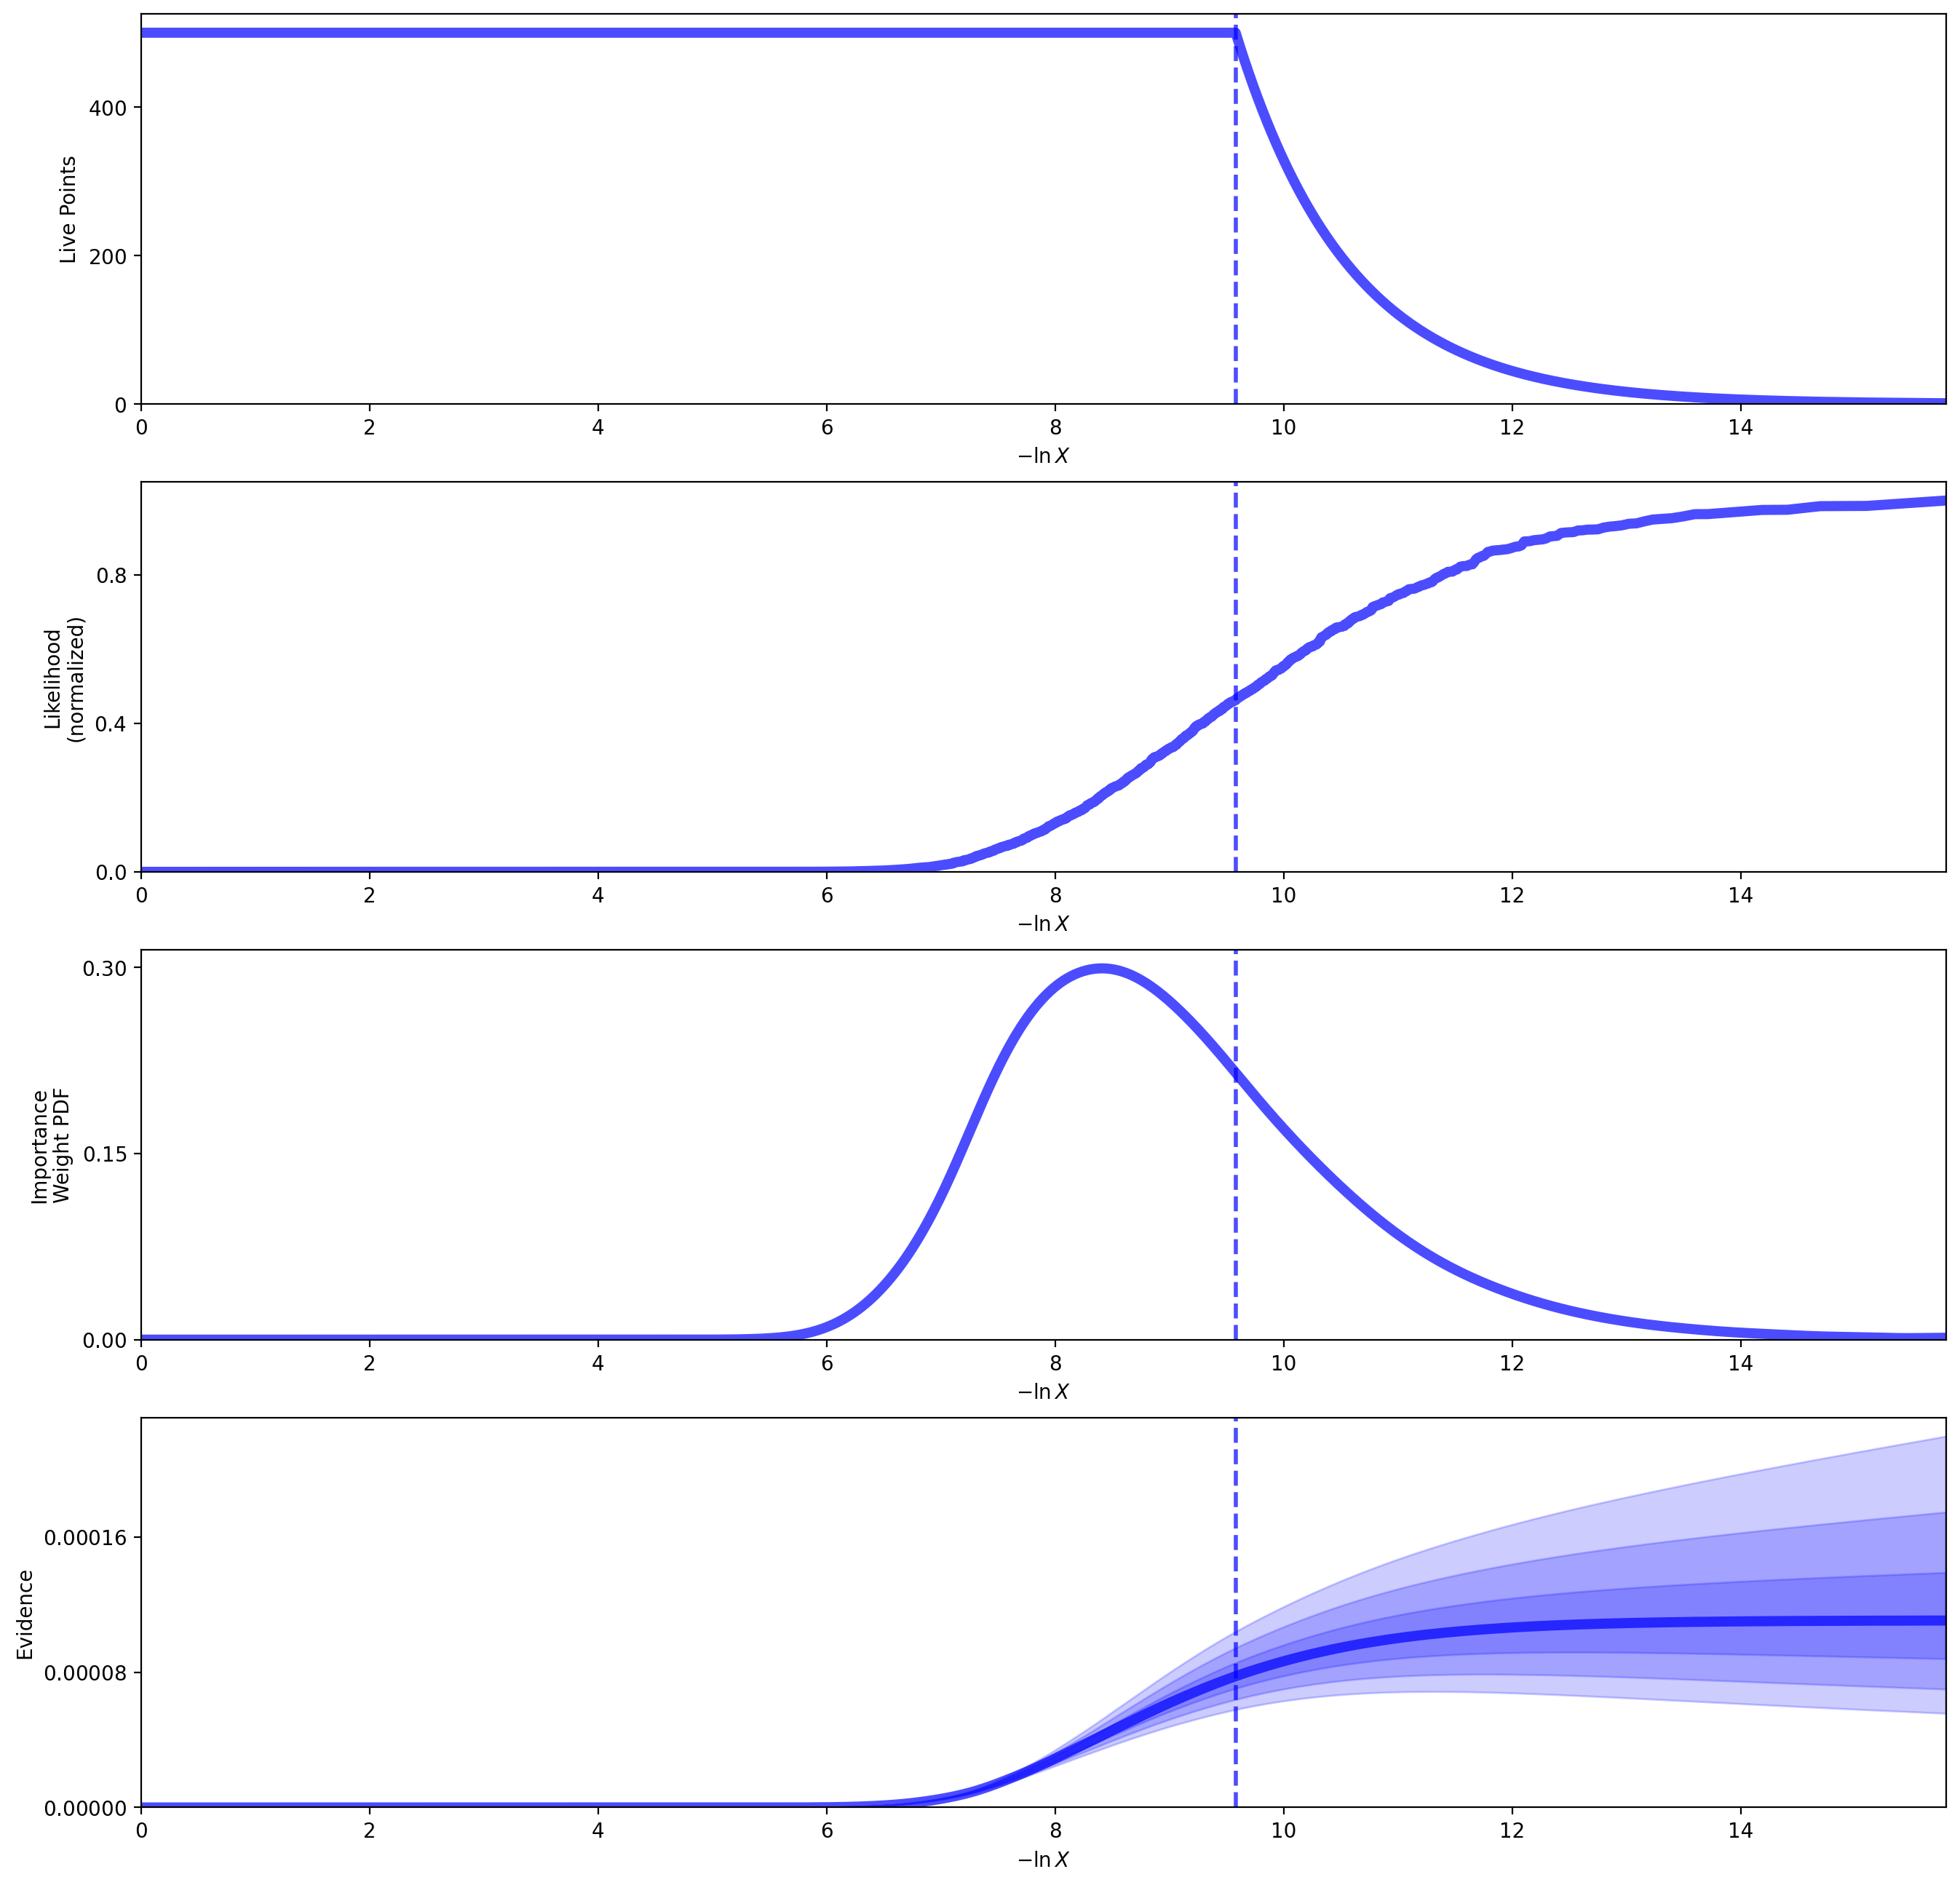

In [30]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

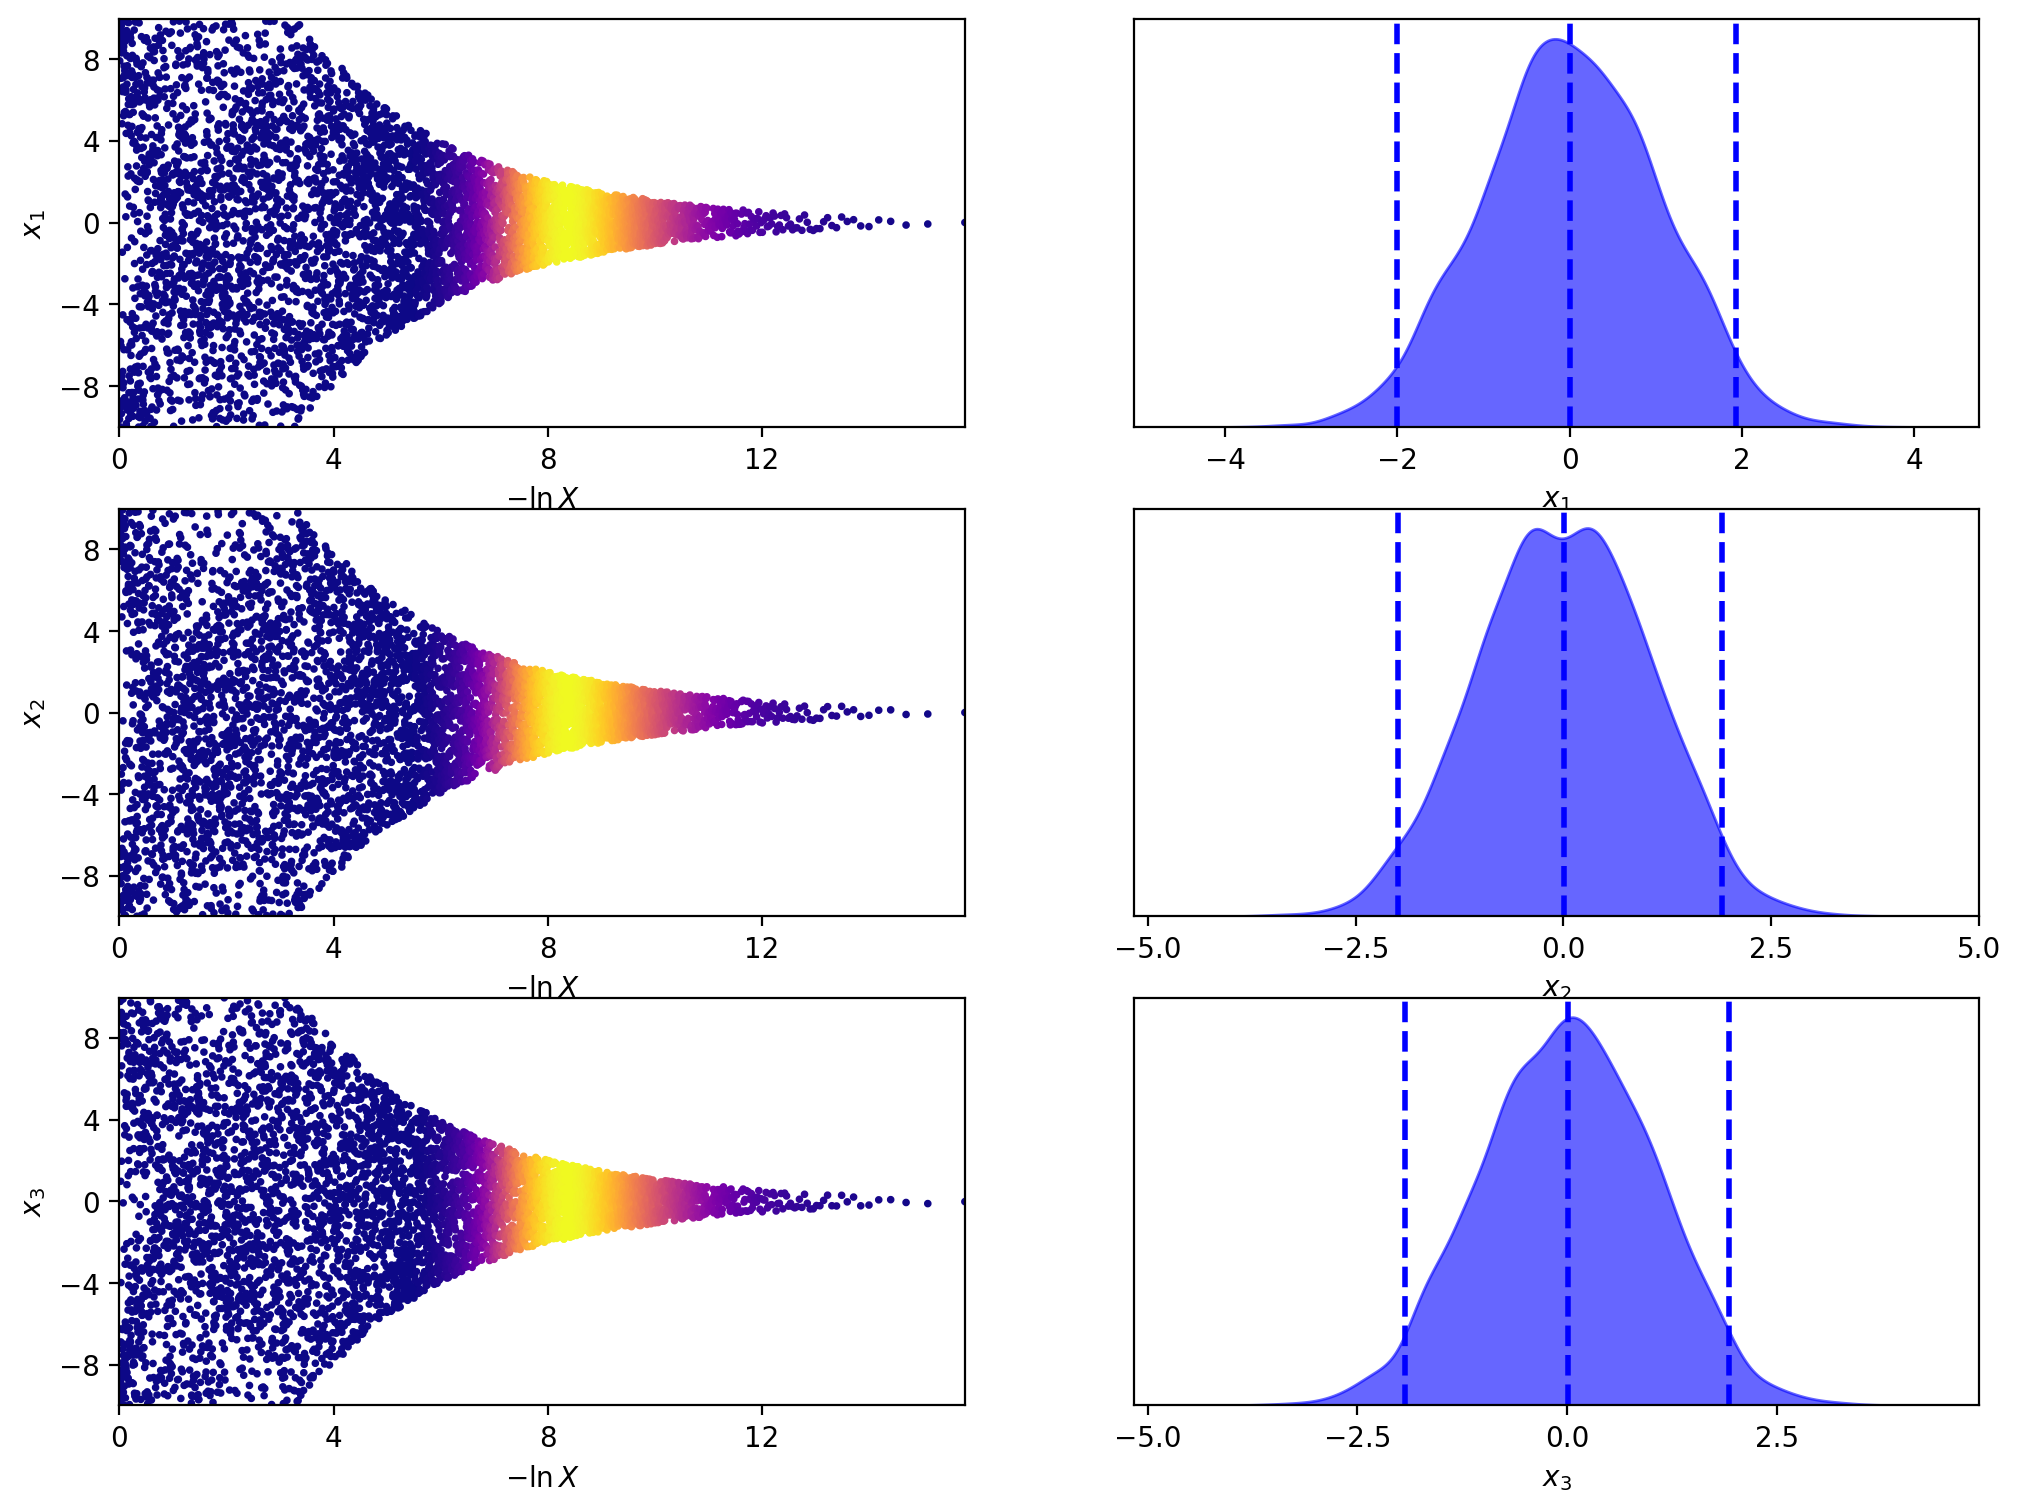

In [31]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

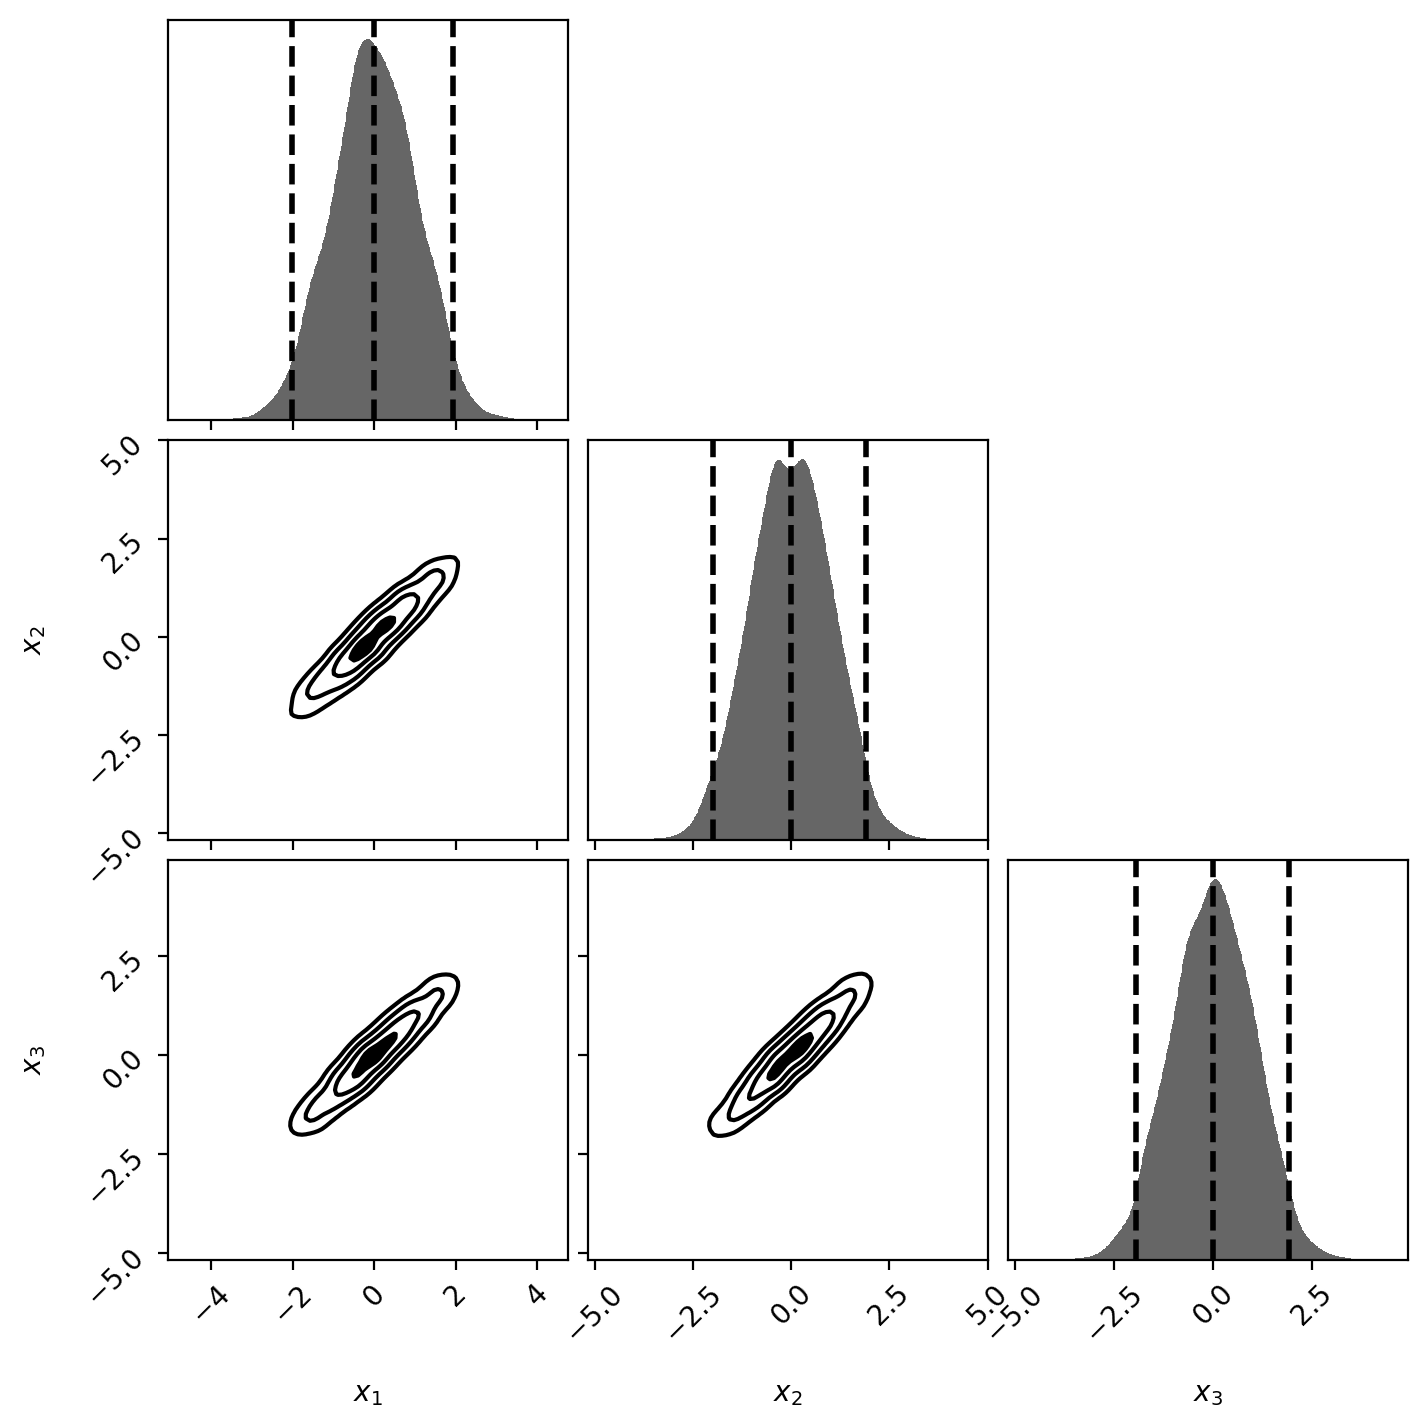

In [32]:
cfig, caxes = dyplot.cornerplot(sresults)

`dynesty` also lets you access many other utilities and analysis outputs. See below. 

In [33]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

68% parameter credible regions are:
 [[-1.0136187972217352, 1.042883085121052], [-1.0110764508596581, 1.0323360046863064], [-1.0504843130944927, 1.0459431276394373]]

Mean and covariance of parameters are: [0.00605106 0.00696624 0.00489269]
[[1.04367268 0.98775601 0.99606915]
 [0.98775601 1.03644386 0.99193139]
 [0.99606915 0.99193139 1.04829541]]


If you want to plot your posterior samples using `corner` or another package, then access the *equally weighted samples*. 

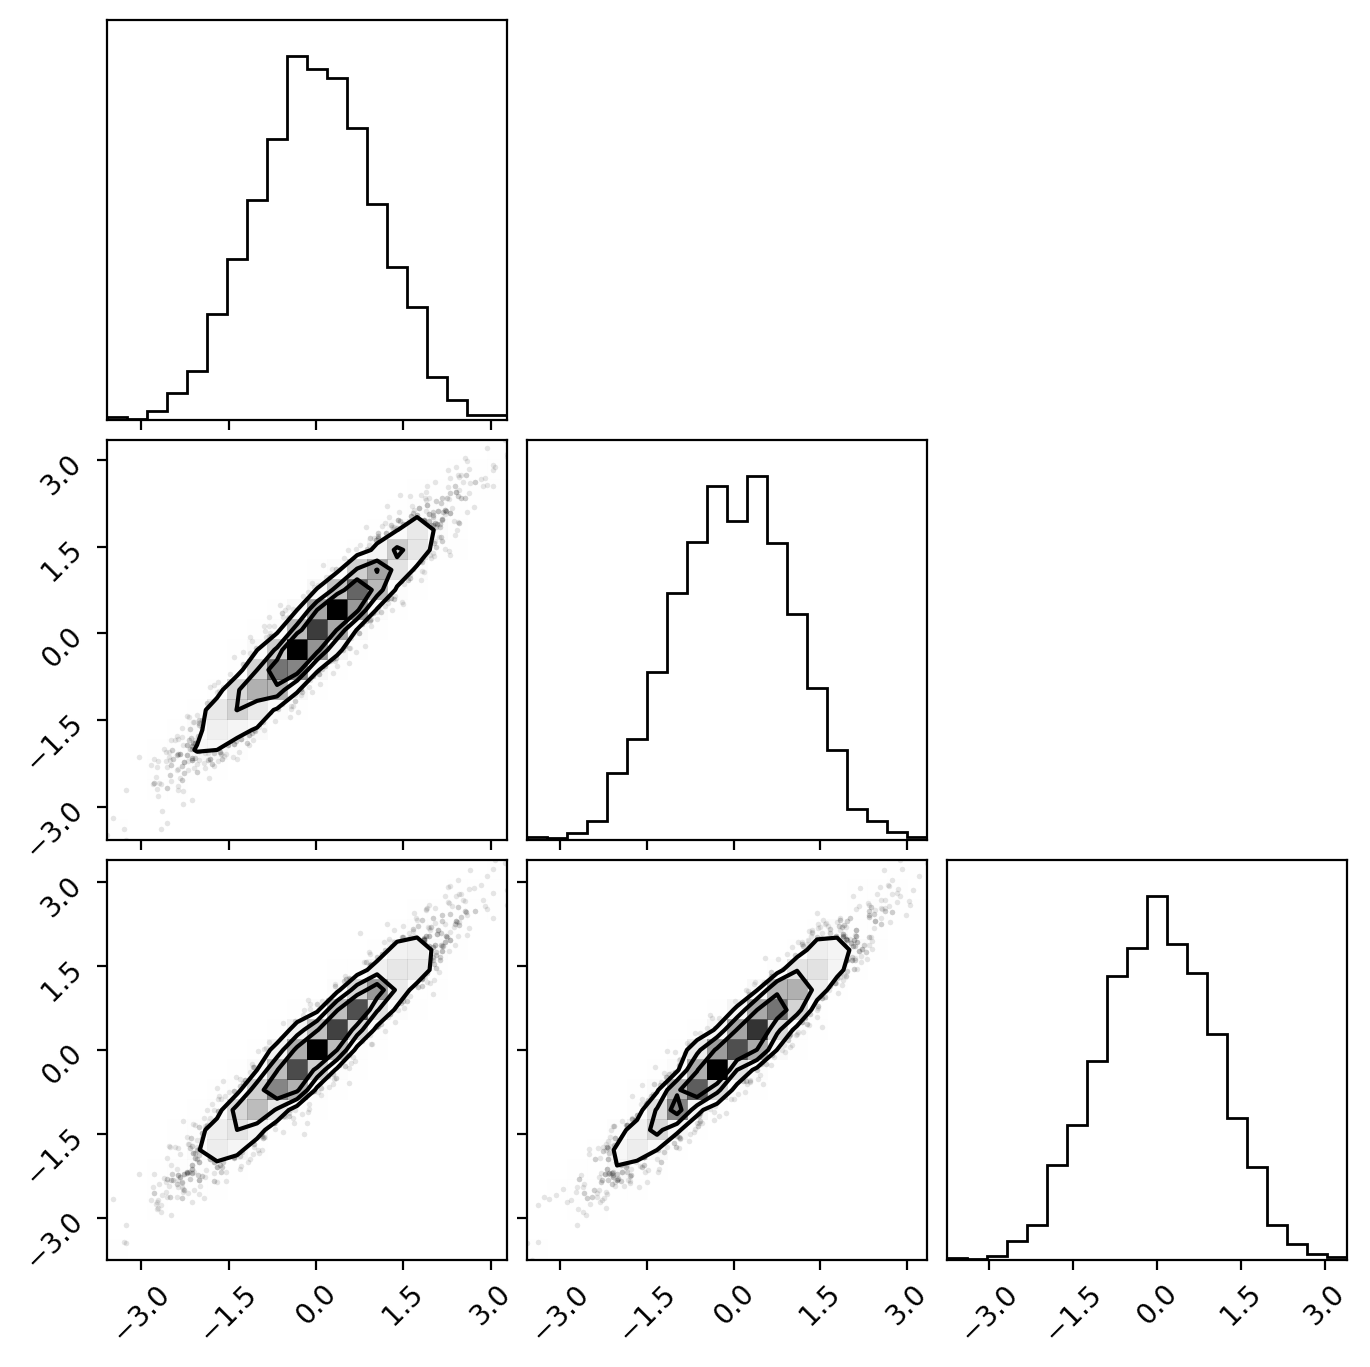

In [34]:
import corner
corner.corner(samples_equal);

The code even helpfully tells you what work you should be citing based on the run configurations that you used.

In [35]:
print(sampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2023): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944


Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:




There is a lot to explore in the `dynesty` package. It is not a panacea, and there are some things you may have to tune, e.g. the **number of initialized live points**, and **the evidence tolerance**. Dig into these caveats in your own time for your own research problems.

Additionally, it implements **dynamic nested sampling** that dynamically allocates live points to explore higher posterior regions better at the expense of increasing the relative evidence uncertainty. See https://dynesty.readthedocs.io/en/latest/dynamic.html. 

###  UltraNest <a class="anchor" id="twob"></a>

*Refs: MLFriends (Buchner, 2014; 2019) using UltraNest https://johannesbuchner.github.io/UltraNest/*

To see how `UltraNest` works compared to standard MCMC algorithms, go [here](https://johannesbuchner.github.io/UltraNest/method.html#visualisation). 

You should have seen this kind of visualization before for Metropolis-Hastings, but this helps make it clear how the new live points are being chosen from within the prior volume, and how the whole set of points are moving up the likelihood surface.

We'll look at an example from [UltraNest's documentation](https://johannesbuchner.github.io/UltraNest/using-ultranest.html). This involves fitting a **spectral line feature**. There are many other tutorials on the documentation to dig into in your own time.

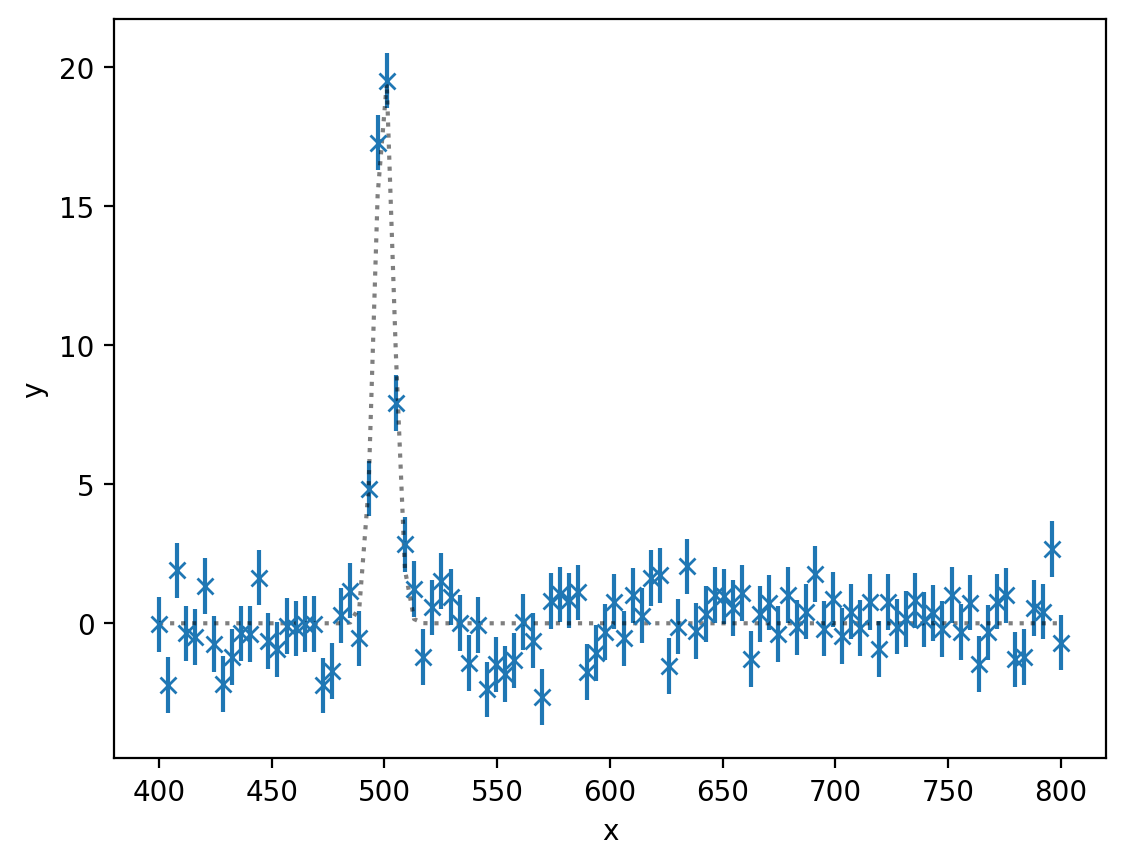

In [36]:
# Generate data over a wavelength range with a noisy signal
x = np.linspace(400, 800, 100)
yerr = 1.0
y = np.random.normal(20 * np.exp(-0.5 * ((x-500)/4.2)**2), yerr)

plt.errorbar(x, y, yerr=yerr, ls=' ', marker='x')
plt.plot(x, 20 * np.exp(-0.5 * ((x-500)/4.2)**2), ls=':', alpha=0.5, color='k')
plt.xlabel('x')
plt.ylabel('y');

This problem has 3 parameters: The location, amplitude and width of the gaussian line. We assume that the noise level is known.

In [37]:
param_names = ['location', 'amplitude', 'width']

As in `dynesty`, the parameter space is defined through a transform from unit values ($0,\ldots,1$) to the physical range.

The next function demonstrates:
- a uniform prior for a location parameter
- a log-uniform prior for a scale parameter
- a log-normal prior

In [39]:
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 400
    hi = 800
    params[0] = cube[0] * (hi - lo) + lo

    # transform amplitude parameter: log-uniform prior
    lo = 0.1
    hi = 100
    params[1] = 10**(cube[1] * (np.log10(hi) - np.log10(lo)) + np.log10(lo))

    # More complex prior, you can use the ppf functions
    # from scipy.stats, such as scipy.stats.norm(mean, std).ppf

    # transform for width:
    # a log-normal centered at 1 +- 1dex
    params[2] = 10**stats.norm.ppf(cube[2], 0, 1)

    return params

Next, we need to specify the data likelihood given certain parameters:

In [40]:
def my_likelihood(params):
    location, amplitude, width = params
    # compute intensity at every x position according to the model
    y_model = amplitude * np.exp(-0.5 * ((x - location)/width)**2)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y)/yerr)**2).sum()
    return like

Ready to sample!

In [41]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          my_prior_transform)

ModuleNotFoundError: No module named 'ultranest'

Take a second to install ipython widgets for some interactive run updates.

In [42]:
!pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.3 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.3 MB 1.0 MB/s eta 0:00:02
   ------------- -------------------------- 0.8/2.3 MB 1.2 MB/s eta 0:00:02
   ----------------- ---------------------- 1.0/2.3 MB 1.2 MB/s eta 0:00:02
   -------------------------- ------------- 1.6/2.3 MB 1.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.3 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 1.4 MB/s eta 0:00:00


In [43]:
result = sampler.run()
sampler.print_results()

AttributeError: 'MultiEllipsoidSampler' object has no attribute 'run'

In [44]:
from ultranest.plot import cornerplot
cornerplot(result)

ModuleNotFoundError: No module named 'ultranest'

**There is a ton more to explore in nested sampling, evidence evaluation, moddel comparison, and parameter estimation.** 

**Alas, we must move on. However, these hands-on tutorials using real packages gives you an idea of the rich array of resources you can use for your own research.** 

**Make sure you know what is going on under the hood though-- remember we're (astro-)physicists after all!**